# Causal Data Science Week 5 Tutorial

In this tutorial we will practice how to learn a causal graph from constraint based structure learning with the PC algorithm. We will go through the algorithm both by-hand and with the CausalDiscoveryTool package.

In [ ]:
!pip install dowhy

In [ ]:
!pip install cdt
!conda install -y r-RCurl
!pip install torchvision
!pip install ges

In [ ]:
!pip install torchvision -q

In [12]:
!pip install pingouin -q

## SGS and PC algorithm

The PC algorithm is a constraint based causal discovery algorithm named after its authors **P**eter Spirtes and **C**lark Glymour. The idea of this algorithm is based on conditional independence testing.

For the simplicity of coding, we will start with a simpler version called SGS algorithm (https://www.researchgate.net/publication/242448131_Causation_Prediction_and_Search). SGS algorithm has the same input/output relations as the PC algorithm for faithful distributions, but has higher complexity as it tests more conditional independences. While the SGS algorithm always considers all possible pairs of nodes in the graph, the PC algorithm only considers adjacent pairs of nodes

Assuming Markov and faithfulness, a CPDAG (completed partially directed acyclic graph) can be estimated. Both algorithms proceed as follows:
- Determine the skeleton
- Determine the v-structures
- Direct as many of the remaining edges as possible.

The implementation below is a naive version of SGS algorithm, where we check the v-structures and direct edges by hands. We go through an example with synthetic dataset. The example graph is taken from: https://stat.ethz.ch/lectures/ss21/causality.php#course_materials.

In [1]:
# import necessary packages
import time
from itertools import combinations

from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg

np.random.seed(0)

Detecting 1 CUDA device(s).


In [ ]:
import cdt

from cdt.utils.R import RPackages, launch_R_script
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.3.2/bin/x64/Rscript'

print(RPackages.pcalg,RPackages.kpcalg,RPackages.RCIT) # have to be True -- all of them

In [8]:
import ges

model_pc = cdt.causality.graph.PC()

In [2]:
noise_intensity = 0.0

df = pd.read_csv('lucas0_train.csv')

noise_filter = (np.random.rand(2000,12) > 1-noise_intensity).astype('int')

df = pd.DataFrame(np.logical_xor(df.values, noise_filter).astype('int'),\
                  columns=df.columns)

In [3]:
pos = {'Smoking':(4,5),
 'Yellow_Fingers':(6.2,2.9),
 'Anxiety':(6.5, 5.5),
 'Peer_Pressure':(5.7, 7),
 'Genetics':(2.5, 4.7),
 'Attention_Disorder':(1.8,2.8),
 'Born_an_Even_Day':(7, 4.5),
 'Car_Accident':(0.5,0.5),
 'Fatigue':(3, 0.5),
 'Allergy':(7.6,0.),
 'Coughing':(5.3, 0.7),
 'Lung_cancer':(4.4,1.9)}

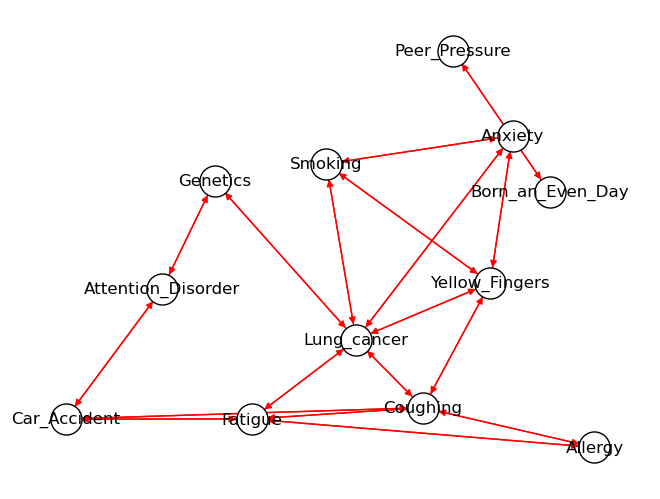

In [6]:
alpha = 0.05

pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

In [19]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

def draw_graph(G):
    pos_a = pos
    pos_nodes = nudge(pos_a, 0.0, -0.45)

    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.margins(0.2)
    nx.draw(G, ax=ax, pos=pos, with_labels=False, node_size=500, node_color='w', edgecolors='black', edge_color=colors)
    nx.draw_networkx_labels(G, ax=ax, pos=pos_nodes, font_size=18)

In [20]:
colors = ['black' if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]

NameError: name 'directed' is not defined

In [21]:

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('Smoking', 'Lung_cancer'),
                           ('Smoking', 'Yellow_Fingers'),
                           ('Anxiety', 'Smoking'),
                           ('Peer_Pressure', 'Smoking'),
                           ('Genetics', 'Lung_cancer'),
                           ('Lung_cancer', 'Coughing'),
                           ('Lung_cancer', 'Fatigue'),
                           ('Genetics', 'Attention_Disorder'),
                           ('Allergy', 'Coughing'),
                           ('Coughing', 'Fatigue'),
                           ('Fatigue', 'Car_Accident'),
                           ('Attention_Disorder', 'Car_Accident'),])

draw_graph(true_graph)
plt.savefig('target_graph.png')

NameError: name 'nodes' is not defined

## SGS Stage 1

In [22]:
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

draw_graph(skeleton)

NameError: name 'nodes' is not defined

In [ ]:
def skeleton_learning(df, alpha=0.05):
    # Initialize fully connected skeleton
    skeleton = nx.Graph(combinations(list(df.columns), 2))
    time_ = []
    # for all pairs of nodes x and y
        # for k = 0,1,...,|V|
    for k in range(len(skeleton.nodes())-1):
        start = time.time()
        for (x, y) in combinations(skeleton.nodes(), 2):
            # for all S subset of |V|\{x,y} s.t. |S|=k
            for s in combinations(set(skeleton.nodes()).difference([x,y]), k):
                # test null hypothesis of conditional independence between x and y given s
                p_val = pg.partial_corr(data=df, x=x, y=y, covar=list(s)).round(3)['p-val'].item()
                # If we fail to reject the null hypothesis then x and y cannot be adjacent
                if p_val > alpha and skeleton.has_edge(x, y):
                    print("removing edge: ", (x, y))
                    skeleton.remove_edge(x, y)
        end = time.time()
        time_.append(end - start)

        draw_graph(skeleton)
        plt.text(0.2, 7, 'k='+str(k), fontsize=44)
        plt.text(0.2, 6.4, 'time: ' + str(round(time_[-1], 2)), fontsize=34)
        plt.savefig('SGS_stage_1n/' + str(k) + '.png')


    return skeleton, time_

In [ ]:
skeleton, time_ = skeleton_learning(df)
draw_graph(skeleton)

In [ ]:
directed = skeleton.to_directed()
colors = ['red' if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]
# draw_graph(directed)

## Identifying v-structures

In [ ]:
from tqdm import tqdm

v_triplets = []
for source in tqdm(directed.nodes):
    middle_nodes = [a for a in skeleton.neighbors(source)]
    for middle_node in middle_nodes:
        end_nodes = [a for a in skeleton.neighbors(middle_node) if a != source]
        for end_node in end_nodes:
            if end_node not in middle_nodes:
                if [end_node, middle_node, source] not in v_triplets:
                    v_triplets.append([source, middle_node, end_node])


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


In [ ]:
unshielded_triplets = []
i = 0
for v_triplet in v_triplets:
    i+=1

    for k in tqdm(range(len(skeleton.nodes())-2)):
        for s in combinations(set(skeleton.nodes()).difference(v_triplet), k):
            s_f = [a for a in s]
            s_f.append(v_triplet[1])
            p_val = pg.partial_corr(data=df, x=v_triplet[0], y=v_triplet[2], covar=list(s_f)).round(3)['p-val'].item()
            if p_val > alpha:
                flag = 1
                break
        if p_val > alpha:
            break
    if p_val < alpha:
        unshielded_triplets.append(v_triplet)
        directed.remove_edges_from([(v_triplet[1], v_triplet[0]), (v_triplet[1], v_triplet[2])])
        colors = ['red'  if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]

        draw_graph(directed)
        plt.text(6.76, 7.7, str(i) + '/' + str(len(v_triplets)), fontsize=54)
        plt.text(-1.05, 8, str(v_triplet), fontsize=20)
        plt.text(-1.05, 7.5, 'Result: ' + str(True), fontsize=18, color='black')
        plt.savefig('SGS_stage_2/' + str(i) + '.png')
    else:
        draw_graph(directed)
        plt.text(6.76, 7.7, str(i) + '/' + str(len(v_triplets)), fontsize=54)
        plt.text(-1.05, 8, str(v_triplet), fontsize=20)
        plt.text(-1.05, 7.5, 'Result: ' + str(False), fontsize=18, color='red')
        plt.savefig('SGS_stage_2n/' + str(i) + '.png')

In [ ]:
draw_graph(directed)

directed.remove_edges_from([('Yellow_Fingers', 'Smoking')])
colors = ['red'  if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]

draw_graph(directed)

plt.savefig('SGS_stage_3/' + str(4) + '.png')

In [ ]:
directed.remove_edges_from([('Fatigue', 'Coughing')])

In [ ]:
draw_graph(directed)

In [ ]:
draw_graph(true_graph)

**The full PC algorithm is available in the CausalDiscoveryTool (cdt) package**. The default CItest we use here is Gaussion CI test. There is also a list of options possible for different CI tests.
```CI_test = {'binary': "pcalg::binCItest",
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}```

In [27]:
alpha = 0.05

pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

ImportError: R Package (k)pcalg/RCIT is not available. RCIT has to be installed from https://github.com/Diviyan-Kalainathan/RCIT

C:/Program Files/R/R-4.2.2/bin/x64/Rscript
C:\Users\EIGHON~1\AppData\Local\Temp\cdt_R_script_aaf7339f-f141-4288-8e2d-d655ff1db05d\instance_test_import.R
C:/Program Files/R/R-4.2.2/bin/x64/Rscript
C:\Users\EIGHON~1\AppData\Local\Temp\cdt_R_script_a69bd847-e427-4326-bd75-1f09e9f31f89\instance_test_import.R
C:/Program Files/R/R-4.2.2/bin/x64/Rscript
C:\Users\EIGHON~1\AppData\Local\Temp\cdt_R_script_b342722c-7611-46cf-9a0b-a621d1bd751d\instance_test_import.R
C:/Program Files/R/R-4.2.2/bin/x64/Rscript
C:\Users\EIGHON~1\AppData\Local\Temp\cdt_R_script_14734fdd-0015-44ce-bad1-249d376372b2\instance_pc.R


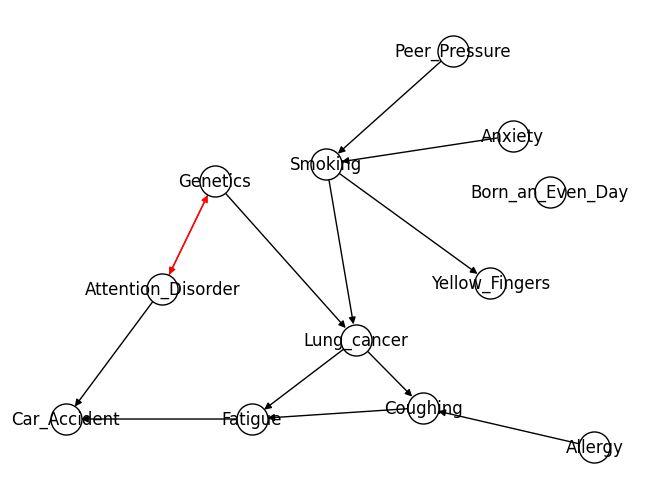

In [ ]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

The results from the PC algorithm is a Markov equivalence class (MEC) that contains two valid DAGs, one of which is the true causal graph. We are not able to orient the edge between $X_1$ and $X_2$ purely based on the observed data. In general, the PC algorithm works well with the number of nodes smaller than 200, but is sensitive to conditional independence tests and the number of samples.

### Background knowledge

In many applications background knowledge of the causal system is available. This information is typically of two kinds: Either it is known that a certain edge must or must not be present, or the orientation of a certain edge is known. For the example above, if we have the knowledge that $X_4$ cannot cause $X_1$, then we are able to orient the edge and therefore obtain the DAG.

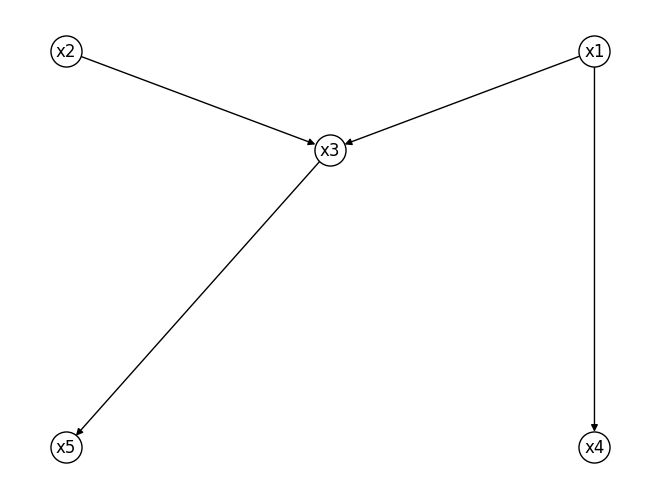

In [ ]:
pc_graph.remove_edge('x4', 'x1')
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

#### Optional: Running PC with background knowledge
In our example, adding background knowledge retrospecitvely resulted in a fully oriented graph. However, in general, orienting edges "manually" can result in mixed graphs in which Meek's rules can be applied again. Thus, it is best if background knowledge about edges is stated before applying SGS/PC. In `cdt` (and in the underlying `pcalg` package) we can only add the prior knowledge about the (non-)existence of edges, but not about their orientation. An example where the skeleton learning of the PC algorithm is forced to never remove the edge between $X_2$ and $X_5$ is shown below.

In [ ]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
### Define background knowledge ###
prior_graph = nx.DiGraph() # Create a graph to hold our background knowledge
prior_graph.add_nodes_from(['x1', 'x2', 'x3', 'x4', 'x5']) # Add nodes
prior_graph.add_edges_from([('x2', 'x5'), ('x5', 'x2')]) # Add prior knowledge of edge between X_2 and X_5 existing
fixed_edges = pd.DataFrame(nx.adjacency_matrix(prior_graph).todense()) # Symmetric adjacency matrix representing edges that exist
fixed_gaps = pd.DataFrame(np.zeros((5,5), dtype=int)) # Symmetric adjacency matrix representing edges that canNOT exist
### Run PC ###
pc.arguments['{CITEST}'] = pc.dir_CI_test[pc.CI_test]
pc.arguments['{METHOD_INDEP}'] = pc.dir_method_indep[pc.CI_test]
pc.arguments['{DIRECTED}'] = 'TRUE'
pc.arguments['{ALPHA}'] = str(pc.alpha)
pc.arguments['{NJOBS}'] = str(pc.njobs)
result = pc._run_pc(df, fixedEdges=fixed_edges, fixedGaps=fixed_gaps, verbose=True)
pc_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
### Visalise ###
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


C:/Program Files/R/R-4.2.2/bin/x64/Rscript
C:\Users\EIGHON~1\AppData\Local\Temp\cdt_R_script_d5453d61-dee5-4e34-b414-8f57d1357b27\instance_pc.R

R Python Error Output 
-----------------------

[Errno 2] No such file or directory: 'C:\\Users\\EIGHON~1\\AppData\\Local\\Temp\\cdt_pc_417136ab-0a83-4adb-a6c6-b37f41f43e9a\\result.csv'


RuntimeError: RProcessError 

As we can see, the graph above contains the edge $X_2 \to X_5$, as required by our prior knowledge.

### Estimating in DoWhy

We can then use this graph in DoWhy and carry on causal effect estimation. Note that we can only use DAGs in DoWhy for the causal model. If the outputs from the PC algorithm are not DAGs then we are not able to use them directly in DoWhy.

In [ ]:
gml

'graph [  directed 1  node [    id 0    label "x1"  ]  node [    id 1    label "x2"  ]  node [    id 2    label "x3"  ]  node [    id 3    label "x4"  ]  node [    id 4    label "x5"  ]  edge [    source 0    target 2    weight 1  ]  edge [    source 0    target 3    weight 1  ]  edge [    source 1    target 2    weight 1  ]  edge [    source 1    target 4    weight 1  ]  edge [    source 2    target 4    weight 1  ]  edge [    source 3    target 0    weight 1  ]]'

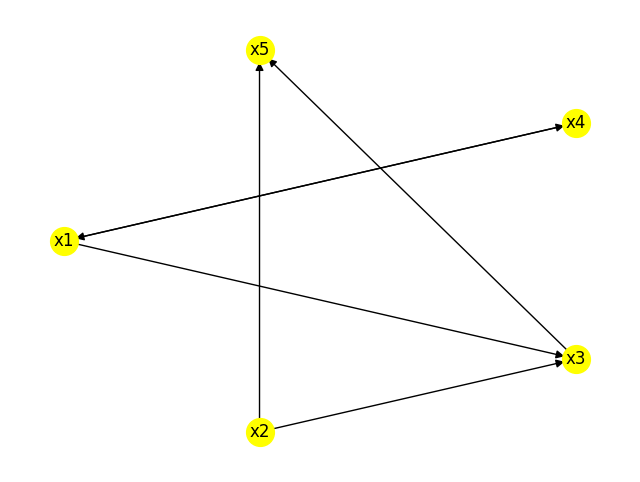

In [ ]:
gml = ''.join(nx.generate_gml(pc_graph))
model = CausalModel(
        data = df,
        treatment='x2',
        outcome='x5',
        graph=gml)
model.view_model()

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

NetworkXError: graph should be directed acyclic

In [ ]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

NameError: name 'identified_estimand' is not defined